In [39]:
%matplotlib inline

In [40]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt

In [41]:
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [42]:
# Some constants 
INPUT_FOLDER = './Data/sample_images/'
patients = os.listdir(INPUT_FOLDER)
patients.sort()

In [43]:
patients

['.DS_Store',
 '00cba091fa4ad62cc3200a657aeb957e',
 '0a099f2549429d29b32f349e95fb2244',
 '0a0c32c9e08cc2ea76a71649de56be6d',
 '0a38e7597ca26f9374f8ea2770ba870d',
 '0acbebb8d463b4b9ca88cf38431aac69',
 '0b20184e0cd497028bdd155d9fb42dc9',
 '0bd0e3056cbf23a1cb7f0f0b18446068',
 '0c0de3749d4fe175b7a5098b060982a1',
 '0c37613214faddf8701ca41e6d43f56e',
 '0c59313f52304e25d5a7dcf9877633b1',
 '0c60f4b87afcb3e2dfa65abbbf3ef2f9',
 '0c98fcb55e3f36d0c2b6507f62f4c5f1',
 '0c9d8314f9c69840e25febabb1229fa4',
 '0ca943d821204ceb089510f836a367fd',
 '0d06d764d3c07572074d468b4cff954f',
 '0d19f1c627df49eb223771c28548350e',
 '0d2fcf787026fece4e57be167d079383',
 '0d941a3ad6c889ac451caf89c46cb92a',
 '0ddeb08e9c97227853422bd71a2a695e',
 '0de72529c30fe642bc60dcb75c87f6bd']

In [44]:
# Load the scans in given folder path
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    
    # This works because of DICOM definiion
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
    
    # Slick thickness is important in later resampling
    for s in slices:
        s.SliceThickness = slice_thickness
    
    return slices

In [45]:
slices = load_scan('./Data/sample_images/' + patients[1])

In [46]:
for s in slices:
    print(s.ImagePositionPatient)

['-145.500000', '-158.199997', '-356.200012']
['-145.500000', '-158.199997', '-353.700012']
['-145.500000', '-158.199997', '-351.200012']
['-145.500000', '-158.199997', '-348.700012']
['-145.500000', '-158.199997', '-346.200012']
['-145.500000', '-158.199997', '-343.700012']
['-145.500000', '-158.199997', '-341.200012']
['-145.500000', '-158.199997', '-338.700012']
['-145.500000', '-158.199997', '-336.200012']
['-145.500000', '-158.199997', '-333.700012']
['-145.500000', '-158.199997', '-331.200012']
['-145.500000', '-158.199997', '-328.700012']
['-145.500000', '-158.199997', '-326.200012']
['-145.500000', '-158.199997', '-323.700012']
['-145.500000', '-158.199997', '-321.200012']
['-145.500000', '-158.199997', '-318.700012']
['-145.500000', '-158.199997', '-316.200012']
['-145.500000', '-158.199997', '-313.700012']
['-145.500000', '-158.199997', '-311.200012']
['-145.500000', '-158.199997', '-308.700012']
['-145.500000', '-158.199997', '-306.200012']
['-145.500000', '-158.199997', '-3

In [47]:
dir(slices[0])

['AcquisitionNumber',
 'BitsAllocated',
 'BitsStored',
 'Columns',
 'FrameOfReferenceUID',
 'HighBit',
 'ImageOrientationPatient',
 'ImagePositionPatient',
 'InstanceNumber',
 'KVP',
 'Modality',
 'PatientBirthDate',
 'PatientID',
 'PatientName',
 'PatientOrientation',
 'PhotometricInterpretation',
 'PixelData',
 'PixelPaddingValue',
 'PixelRepresentation',
 'PixelSpacing',
 'PositionReferenceIndicator',
 'RescaleIntercept',
 'RescaleSlope',
 'Rows',
 'SOPClassUID',
 'SOPInstanceUID',
 'SamplesPerPixel',
 'SeriesDescription',
 'SeriesInstanceUID',
 'SeriesNumber',
 'SliceLocation',
 'SliceThickness',
 'SpecificCharacterSet',
 'StudyInstanceUID',
 'WindowCenter',
 'WindowWidth',
 '__cmp__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__init__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setatt

In [48]:
np.array([s.pixel_array for s in slices]).shape

(109, 512, 512)

In [49]:
np.stack([s.pixel_array for s in slices]).shape

(109, 512, 512)

In [50]:
len(slices)

109

In [51]:
def get_pixels_hu(slices):
    #np.array() should also work according to the preceding cells
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    # TODO: Understand what `intercept` and `slope` is
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

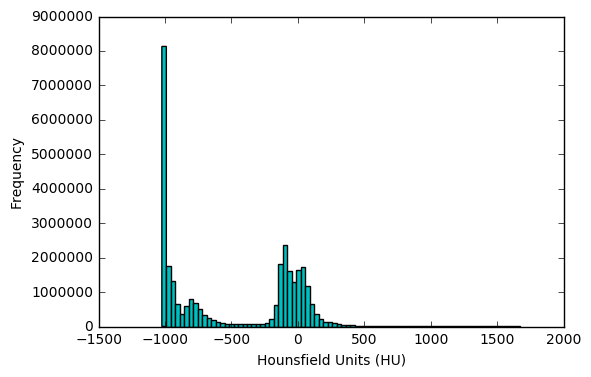

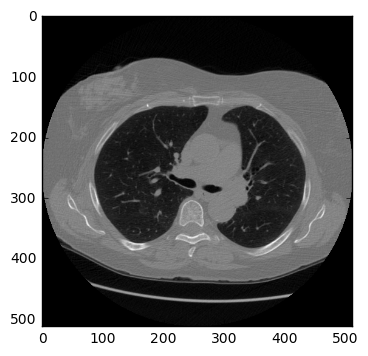

In [52]:
# patients[0] is .DS_Store on a Mac
first_patient = load_scan(INPUT_FOLDER + patients[2])
first_patient_pixels = get_pixels_hu(first_patient)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(first_patient_pixels[80], cmap=plt.cm.gray)
plt.show()

In [70]:
verts, faces = measure.marching_cubes(first_patient_pixels, 400)

In [71]:
verts.shape

(464314, 3)

In [72]:
verts[faces].shape

(906723, 3, 3)

In [73]:
verts[faces[0]]

array([[  0.00000000e+00,   1.96935484e+02,   8.50000000e+01],
       [  8.27586207e-02,   1.97000000e+02,   8.50000000e+01],
       [  0.00000000e+00,   1.97000000e+02,   8.48208955e+01]])

In [74]:
mesh = Poly3DCollection(verts[faces], alpha=0.1)

In [75]:
mesh

In [76]:
mesh.set_facecolor([0.5, 0.5, 1])

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(212, projection='3d')
# ax.add_collection3d(mesh)
# ax.set_xlim(0, first_patient_pixels.shape[0])
# ax.set_ylim(0, first_patient_pixels.shape[1])
# ax.set_zlim(0, first_patient_pixels.shape[2])
# plt.show()

In [80]:
ax.add_collection3d(mesh)
ax.set_xlim(0, first_patient_pixels.shape[0])
ax.set_ylim(0, first_patient_pixels.shape[1])
ax.set_zlim(0, first_patient_pixels.shape[2])
plt.show()

In [79]:
plt.show()

In [68]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    # p = image.transpose(2,1,0)
    p = image
    
    verts, faces = measure.marching_cubes(p, threshold)
    print(verts[faces].shape)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    print(fig)

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

(906723, 3, 3)
Figure(720x720)


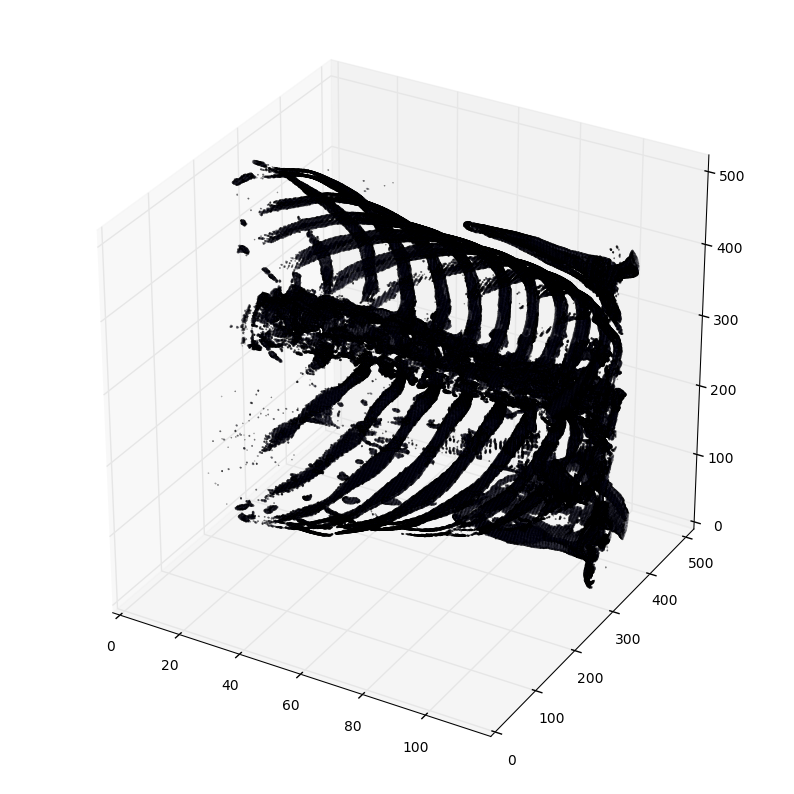

In [69]:
plot_3d(first_patient_pixels, 400)